<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TOP" data-toc-modified-id="TOP-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TOP</a></span></li><li><span><a href="#Reading-event-log" data-toc-modified-id="Reading-event-log-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading event log</a></span></li><li><span><a href="#Process-as-constraints-from-process-mining" data-toc-modified-id="Process-as-constraints-from-process-mining-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process as constraints from process mining</a></span></li><li><span><a href="#Constructing-ground-truth" data-toc-modified-id="Constructing-ground-truth-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Constructing ground truth</a></span></li><li><span><a href="#Repairs" data-toc-modified-id="Repairs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Repairs</a></span></li></ul></div>

# TOP

The approach used here is inspired from results of [Analyzing the Trajectories of Patients with Sepsis using Process Mining](https://www.researchgate.net/publication/316880149_Analyzing_the_Trajectories_of_Patients_with_Sepsis_using_Process_Mining) paper. A quick glance at it is recommended.

Process mining is
the task of extracting a process based on event data. In 
[this](https://www.researchgate.net/publication/316880149_Analyzing_the_Trajectories_of_Patients_with_Sepsis_using_Process_Mining)  paper, the
authors analyzed the trajectories of patients in a Dutch hospital
from their registration in the emergency room until their discharge.
From event-logs, i.e. a list of chronologically ordered events, they
extracted a process diagram: a directed graph of allowed sequence
of events. The process diagram can thus be used as constraints for
the patients trajectories. The result of process mining is inherently
noisy, as the process (constraint) is defined downstream to sampling.
To run our experiments, we use the process diagram reported in the aforementioned paper (reproduced below) as our 𝑆. As groundtruth 𝐺∗, we extract the patient paths that
that satisfy 𝑆.

In [1]:
from igr import *

import pandas as pd
import numpy as np
import networkx as nx
from bs4 import BeautifulSoup
import os
import graphviz

import pm4py

log = pm4py.read_xes('data/sepsis_case/Sepsis_Cases_Event_Log.xes')

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

# Reading event log

In [2]:
logistic_events = ['ER Registration', 'ER Triage','ER Sepsis Triage', 'Admission NC',
       'Release A', 'Return ER', 'Admission IC', 'Release B', 'Release C',
       'Release D', 'Release E']
release_events = [e for e in logistic_events if "Release" in e]

In [3]:
df = pm4py.convert_to_dataframe(log)
df = df[["case:concept:name", "time:timestamp", "concept:name"]]
df.columns = ["patient", "ts", "event"]
df["event"] = df["event"].astype(str)
df = df[df["event"].apply( lambda e : e in logistic_events)]
df["next"] = None
df.head()

,patient,ts,event,next
0,A,2014-10-22 11:15:41+02:00,ER Registration,None
4,A,2014-10-22 11:33:37+02:00,ER Triage,None
5,A,2014-10-22 11:34:00+02:00,ER Sepsis Triage,None
8,A,2014-10-22 14:13:19+02:00,Admission NC,None
21,A,2014-11-02 15:15:00+01:00,Release A,None


In [4]:
for g,r in df.groupby("patient"):
    df.loc[r.index,"next"] = np.append(r["event"].iloc[1:].values, ["end"])

df

,patient,ts,event,next
0,A,2014-10-22 11:15:41+02:00,ER Registration,ER Triage
4,A,2014-10-22 11:33:37+02:00,ER Triage,ER Sepsis Triage
5,A,2014-10-22 11:34:00+02:00,ER Sepsis Triage,Admission NC
8,A,2014-10-22 14:13:19+02:00,Admission NC,Release A
21,A,2014-11-02 15:15:00+01:00,Release A,end
...,...,...,...,...
15204,KNA,2014-12-12 05:06:38+01:00,Admission NC,Release A
15210,KNA,2014-12-16 17:00:00+01:00,Release A,end
15211,LNA,2014-12-03 10:50:28+01:00,ER Registration,ER Triage
15212,LNA,2014-12-03 10:54:19+01:00,ER Triage,ER Sepsis Triage


In [5]:
H = []
for j,(patient,r) in enumerate(df.groupby("patient")):
    
    GA = nx.Graph()
    
    #unique start and end nodes per patient
    start = -(j+1)*2
    end = start - 1
    
    GA.add_node(start)
    GA.nodes[start]["label"] = "start"
    
    GA.add_node(end)
    GA.nodes[end]["label"] = "end"
    
    prev = start
    
    for i,e in r.iterrows():
        
        GA.add_node(i)
        GA.nodes[i]["label"]=e["event"]
        GA.add_edge(i, prev)
        prev = i
            
    
    GA.add_edge(prev, end)

    H.append(GA.copy())

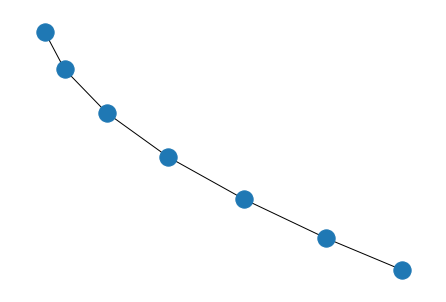

In [6]:
nx.draw(H[0])

In [7]:
G = nx.Graph()
for j,(patient,r) in enumerate(df.groupby("patient")):
    
    #unique start and end nodes per patient
    start = -j*2
    end = start - 1
    
    G.add_node(prev)
    G.nodes[prev]["label"] = "start"
    
    G.add_node(end)
    G.nodes[end]["label"] = "end"
    
    prev = start
    
    for i,e in r.iterrows():
        
        G.add_node(i)
        G.nodes[i]["label"]=e["event"]
        G.add_edge(i, prev)
        prev = i
            
    
    G.add_edge(prev, end)
    
len(G.nodes)

7626

# Process as constraints from process mining

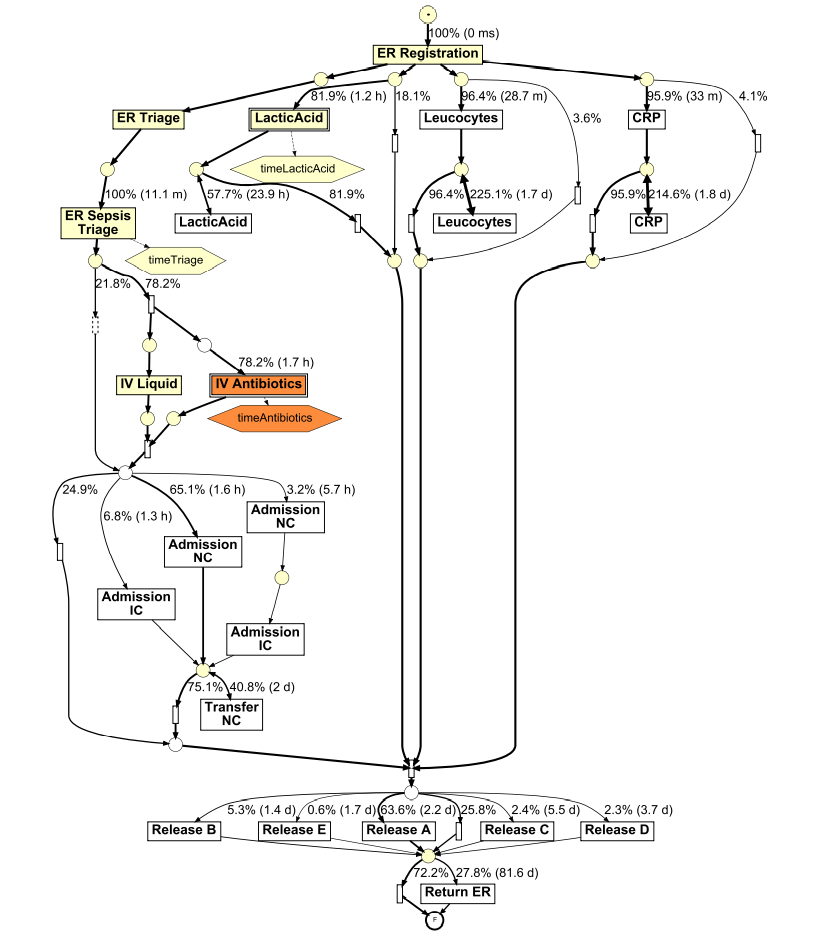

In fact, the process diagram extracted is a petri net, with transitional states. We convert it to directed graph by removing transition states but keeping start and end nodes.
We keep only logistic events, otherwise the process is fully connected and we cannot use it as constraints.
The exercise remains interesting as the path through the hospital is one of the desired questions to answer in the original paper.

In [8]:
P = nx.Graph()
P.add_nodes_from(logistic_events)
P.add_nodes_from(["start", "end"])

In [9]:
P.add_edge("start", "ER Registration")
P.add_edge("ER Registration", "ER Triage")
P.add_edge("ER Triage", "ER Sepsis Triage")
P.add_edge("ER Sepsis Triage","Admission NC")
P.add_edge("ER Sepsis Triage","Admission IC")
P.add_edge("Admission NC","Admission IC")
P.add_edge("Admission IC","Transfer NC")
P.add_edges_from([("ER Sepsis Triage", r) for r in release_events])
P.add_edges_from([("Admission IC", r) for r in release_events])
P.add_edges_from([("Admission NC", r) for r in release_events])
P.add_edges_from([(r, "Return ER") for r in release_events])
P.add_edges_from([(r, "end") for r in release_events])
P.add_edge("Admission IC","end")
P.add_edge("Admission NC","end")
P.add_edge("Return ER", "end")
P.add_edge("ER Sepsis Triage", "end")
P.add_edges_from(zip(P.nodes, P.nodes))

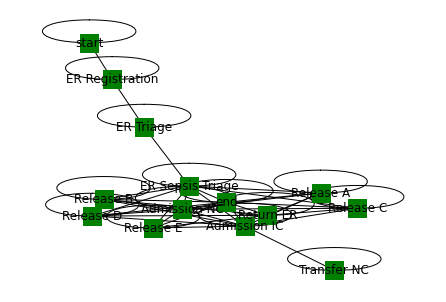

In [10]:
draw_S(P)

/tmp/ipykernel_298/3461434318.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  draw_G(np.random.choice(H), P)


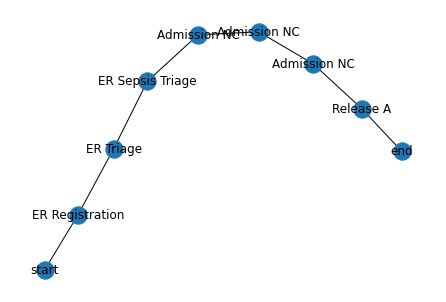

In [11]:
draw_G(np.random.choice(H), P)

# Constructing ground truth

not all examples follow the process exactly:

In [12]:
H_iscorrect = [len(violations(g, P)) == 0 for g in H]
sum(H_iscorrect) / len(H)

0.9695238095238096

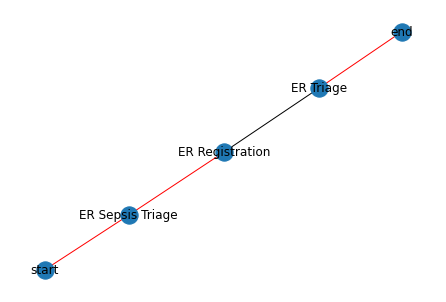

In [13]:
draw_G(H[np.argmin(H_iscorrect)],P)

In [14]:
G_opt = nx.union_all([g for g in H if len(violations(g, P)) == 0])
len(G_opt.nodes) / len(G.nodes)

0.968004196170994

In [15]:
len(G_opt.nodes)

7382

In [16]:
len(H)

1050

In [17]:
print( "|V| = ", len(G_opt.nodes))
print("|E|/|V| =", len(G_opt.edges) / len(G_opt.nodes))
print( "|L| = ", len(P.nodes))
print("|N|/|L| =", len(P.edges) / len(P.nodes))

|V| =  7382
|E|/|V| = 0.8620969926849092
|L| =  14
|N|/|L| = 3.5714285714285716


# Repairs

Very long, we use only a part of it

In [18]:
G_opt = nx.union_all([g for g in H[:300] if len(violations(g, P)) == 0])
len(G_opt.nodes)

2134

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
G = force_inject_violations(G_opt, P, 0.08, 0.12)

In [22]:
x = []
for noise in [(0.08, 0.12), (0.18, 0.22), (0.27,0.33)]:
    for i in range(20):
        
        #inject noise
        G = force_inject_violations(G_opt, P, *noise)
        #generate repairs
        df = generate_all_repairs(G_opt, P, G, repair(G.copy(),P), steps=len(G)*2)
        df["noise"] = str(noise)
        
        x.append(df.copy())
                
df = pd.concat(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [23]:
df

,G,S,G_opt,R,G',Answers,Q_difficulty,framework,user,noise
0,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[yes, yes, yes, yes, yes, no, no, no, yes, yes...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userRandom,"(0.08, 0.12)"
1,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[delete, (13947, ER Triage), (11335, Admission...","[(2, 14), (2, 6), (2, 12), (2, 14), (2, 13), (...",gree,userRandom,"(0.08, 0.12)"
2,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[(11303, Release B), (-18, Release E), (-18, e...","[(2, 29), (2, 29), (2, 29), (2, 29), (2, 29), ...",perm,userRandom,"(0.08, 0.12)"
3,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[(11303, start), (13947, Release D), (11335, R...","[(2, 13), (2, 13), (2, 12), (2, 14), (2, 11), ...",term,userRandom,"(0.08, 0.12)"
4,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userGreedy,"(0.08, 0.12)"
...,...,...,...,...,...,...,...,...,...,...
7,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[(10243, Admission NC), (10593, ER Registratio...","[(2, 8), (2, 13), (2, 11), (2, 11), (2, 7), (2...",term,userGreedy,"(0.27, 0.33)"
8,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[yes, no, no, no, no, no, no, no, no, no, yes,...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userOracle,"(0.27, 0.33)"
9,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[(10243, Return ER), (10593, ER Registration),...","[(2, 10), (2, 13), (2, 13), (2, 13), (2, 14), ...",gree,userOracle,"(0.27, 0.33)"
10,"(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(ER Registration, ER Triage, ER Sepsis Triage,...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","(-2, -3, 0, 4, 5, 8, 21, -4, -5, 297, 298, 299...","[(10243, Return ER), (10593, ER Registration),...","[(2, 29), (2, 29), (2, 29), (2, 29), (2, 29), ...",perm,userOracle,"(0.27, 0.33)"


In [24]:
df.to_pickle("temp/sepsis_repairs.pickle")